# Plan of Attack <a name = "planattack" ><a/>

### [Problem](#problem)

### [Data Analysis](#viewdata) 
1. [Import librairies](#importlibrairies)
2. [Import and Analyse Data](#importdata)
3. [Data Summary](#1stconclusion)

### [Feature Extraction & Engineering](#featureextraction)
1. [Data Preprocessing](#datapreprocessing)
2. [Creat X data and y data](#createXandy)
3. [Unscale data](#unscale)

### [Model Selection](#modelselection)
1. [Stacking models](#stackmodel)     
A. [Case 1: Data Base](#case1)    
    A.1 [Tree Models](#randomforesttree)    
    A.2 [Logistic Regression](#logisticregression)  
    A.3 [SVM](#svm)    
B. [Case 2: one-hot coding features](#case2)
2. [Concat](#concat)
3. [Final model](#finalmodel)

----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------



## Problem: <a name = "problem" ><a/>

#### The company receives many claims from its customers everyday, and the claims need different levels of check. So that the company wants to build a system which can automatize the process of determining to which level a claim belongs

 The "target" column in the train set is the variable to predict. It is equal to 1 for claims suitable for an accelerated approval.

 It means category 1 contains claims for which approval could be accelerated, and the second one contains claims for which additional information is required (in other words, they cannot be accelerated)

#### The task is to predict a probability ("PredictedProb") for each claim in the test set.

## Data Analysis <a name = "viewdata" ><a/>

### Import librairies <a name = "importlibrairies" ><a/>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_predict

### Import and Analyse data <a name = "importdata" ><a/>

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [4]:
test.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.375465e+00,11.361141,C,4.200778,6.57700,2.081784,1.784386,0.011094,9.523810,...,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,2,-4.903407e-07,8.201529,C,4.544371,6.55010,1.558442,2.467532,0.007164,7.142858,...,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
3,7,2.661870e+00,3.041241,C,1.657216,9.77308,2.078337,1.430855,1.252157,7.959596,...,4.404040,8.163614,1.100329e+00,B,1.988688,1.558753,2.448814,0,5.385474,1.493777e+00
4,10,1.252822e+00,11.283352,C,4.638388,8.52051,2.302484,3.510159,0.074263,7.612904,...,6.580644,1.325654,2.584588e-01,A,1.863796,2.666478,2.374275,0,0.681672,2.264151e+00


In [5]:
print('Shape for training data:' , train.shape)
print('Shape for test data:', test.shape)

Shape for training data: (114321, 133)
Shape for test data: (114393, 132)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114393 entries, 0 to 114392
Columns: 132 entries, ID to v131
dtypes: float64(108), int64(5), object(19)
memory usage: 115.2+ MB


#### Missing Data

In [6]:
#missing training data 
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Missing data in training data:", len(missing_data[missing_data['Total'] > 0 ]))
#missing_data[missing_data['Total'] > 40000]

Missing data in training data: 119


In [7]:
#missing test data 
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Missing data in test data:", len(missing_test[missing_test['Total'] > 0 ]))
#missing_test[missing_test['Total'] > 40000]


Missing data in test data: 119


#### Correlation

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/pandas/core/dtypes/common.py:1817: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  return _get_dtype_from_object(np.dtype(dtype))
/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:
/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


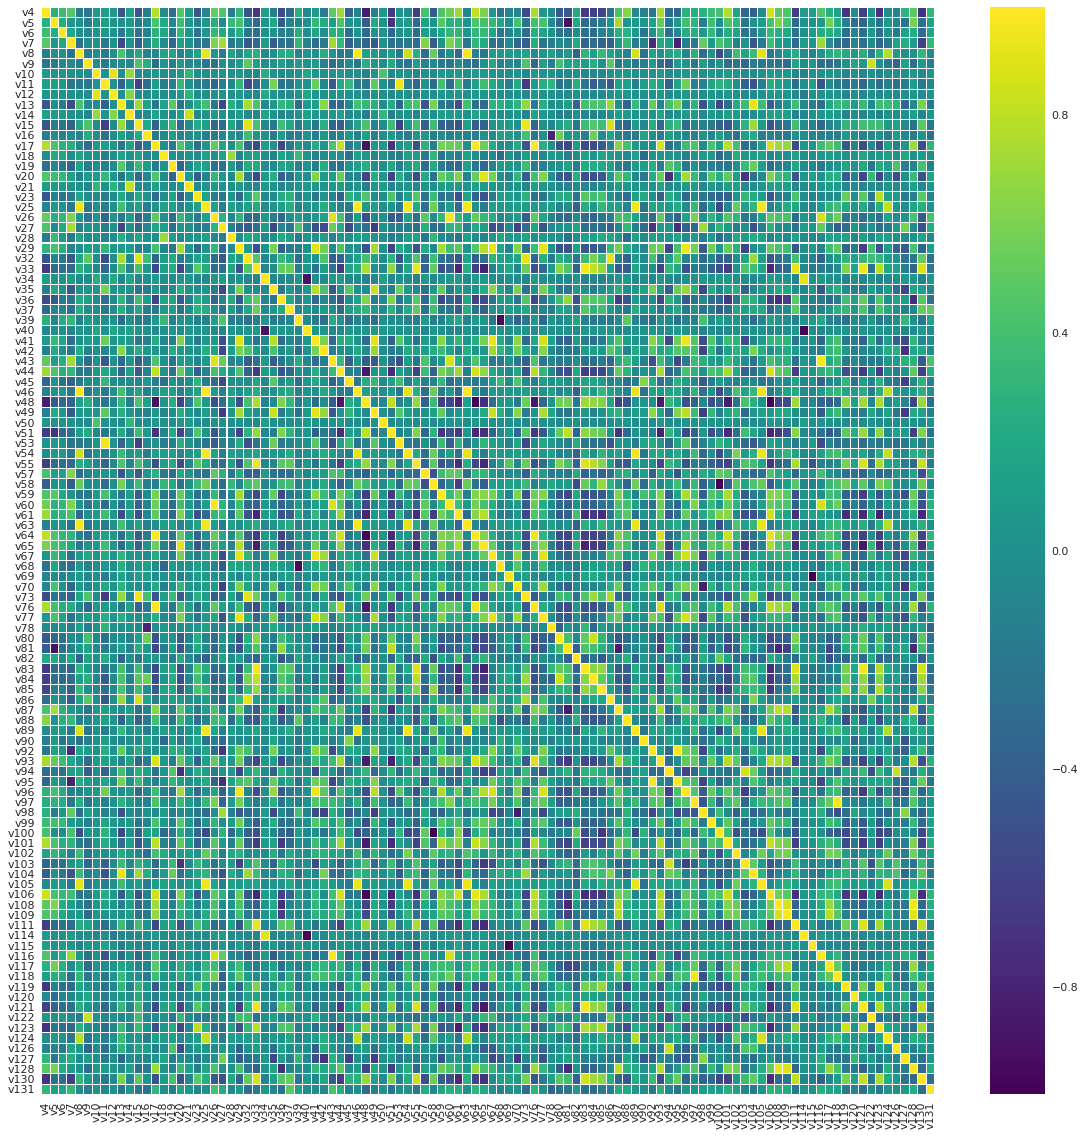

In [12]:
corrMatrix = train.select_dtypes(include = ['Float64']).iloc[:,2:].corr()
sns.set(font_scale = 1.1)
plt.figure(figsize = (20,20))
sns.heatmap(corrMatrix, vmax =.8, linewidths = 0.01, cmap ='viridis', linecolor = 'white')

#### Checking Target and its distribution

0    27300
1    87021
Name: target, dtype: int64


/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


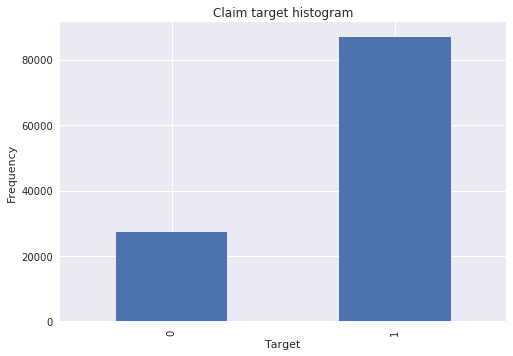

In [10]:
#Checking target
count_target = pd.value_counts(train['target'], sort = True).sort_index()
print(count_target)
count_target.plot(kind= 'bar')
plt.title('Claim target histogram')
plt.xlabel('Target')
plt.ylabel('Frequency')

### Data Summary <a name = "1stconclusion" ><a/>

##### Training data: 
- 114 321 observations (rows) x 133 features (columns, including target)
- Column "ID": the ID of each row, not being used as predictor
- Column "target": the target of each row, not being used as predictor
- All other predictors are unlabelled
- types: float64(108), int64(6), object(19)
- Numbers of Columns with missing value: 119 whose 102 columns have more than 48 619 missing values with percentage 42,52%
- There are many Colums which have the same percentage of missing values ==> **correlated**
- Target: There are 27300 values 0 and 87021 values 1


##### Test data: 
- 114 393 observations (rows) x 132 features (columns)
- Column "ID": the ID of each row, not being used as predictor
- All other predictors are unlabelled
- types: float64(108), int64(5), object(19)
- Numbers of Columns with missing value: 119 whose 102 columns have more than 48 619 missing values with percentage 42,52%


#### [Back to Plan](#planattack)

## Feature Extraction & Engineering <a name = "featureextraction" ><a/>

### Data Preprocessing <a name = "datapreprocessing" ><a/>

In [12]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [13]:
def factorize(train, test):
    for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(), test.iteritems()):
        if train_series.dtype == 'O': #check if object
            train[train_name], tmp_indexer = pd.factorize(train[train_name])
            # pd.factorize will return, in second position, the list of unique values (or categorical labels) in the provided 
            # column, in first position, the indices that would let you recreate the original column from the unique values
            
            # train[train_name] will be replaced by its index-based representation, 
            # tmp_indexer will contains the unique values in the original train[train_name].

            test[train_name] = tmp_indexer.get_indexer(test[train_name])
            #  get_indexer will return the indices where the values in test[test_name] are to be found in tmp_indexer
            #  the current test column is replaced by a list of indices in the exact same way the corresponding train column was in the line above.
              
        else:   # else if int or float
            tmp_len = len(train[train_series.isnull()])
            if tmp_len > 0:
                train.loc[train_series.isnull(), train_name] = -2
            tmp_len = len(test[test_series.isnull()])
            if tmp_len > 0:
                test.loc[test_series.isnull(), test_name] = -2
    return train, test

def preprocess_data(train, test):
    train = train.drop((missing_data[missing_data['Total'] > 40000]).index,axis =1)
    test = test.drop((missing_data[missing_data['Total'] >40000]).index, axis = 1)
    
    
    train, test = factorize(train, test)

    return (train, test)

        

In [14]:
train, test = preprocess_data(train, test)

In [15]:
print('Shape of training data:', train.shape)
print('Shape of test data:', test.shape)

Shape of training data: (114321, 31)
Shape of test data: (114393, 30)


In [16]:
train.head()

,ID,target,v3,v10,v12,v14,v21,v22,v24,v31,...,v74,v75,v79,v91,v107,v110,v112,v114,v125,v129
0,3,1,0,0.503281,6.085711,11.636387,7.730923,0,0,0,...,0,0,0,0,0,0,0,15.634907,0,0
1,4,1,0,1.312910,6.507647,11.636386,6.763110,1,0,0,...,0,0,1,1,1,1,1,10.308044,1,0
2,5,1,0,0.765864,6.384670,9.603542,5.245035,2,1,0,...,0,1,0,2,2,0,2,11.205561,2,2
3,6,1,0,6.542669,9.646653,14.094723,7.517125,3,2,1,...,0,0,2,1,1,0,3,13.777666,3,1
4,8,1,0,1.050328,6.320087,10.991098,6.414567,4,1,0,...,0,0,3,2,2,1,4,14.097099,4,0


In [17]:
test.head()

,ID,v3,v10,v12,v14,v21,v22,v24,v31,v34,...,v74,v75,v79,v91,v107,v110,v112,v114,v125,v129
0,0,0,1.312911,6.961173,12.230137,7.437806,11111,1,0,5.228503,...,0,0,13,1,1,1,1,12.246698,1,0
1,1,0,1.291029,6.618289,10.760796,5.895192,310,2,0,8.387431,...,0,0,0,3,3,0,10,16.284938,75,0
2,2,0,1.575492,6.894249,13.306189,8.253452,-1,4,0,7.958990,...,0,0,3,3,3,1,20,15.622710,48,0
3,7,0,1.575493,6.856236,10.397026,5.539484,426,1,0,6.223849,...,0,0,3,1,1,1,7,13.701587,30,0
4,10,0,1.050328,6.273627,11.354501,6.741530,3796,1,0,5.476858,...,0,0,3,1,1,1,15,13.395401,38,0


In [18]:
test = test.fillna(test.mean())

### Create X data and y data <a name = "createXandy" ><a/>

In [19]:
X_train = train.ix[:, train.columns != 'target']
y_train = train.ix[:, train.columns == 'target']

X_test = test.ix[:, test.columns != 'target']

test_id = X_test['ID']

X_train = X_train.drop('ID', axis =1)
X_test = X_test.drop('ID', axis =1 )

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.
/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [20]:
#calculate number of categorical features and numerical features
categorical_features_train = X_train.select_dtypes(include=["object"]).columns
numerical_features_train = X_train.select_dtypes(exclude=["object"]).columns
train_cat = X_train[categorical_features_train]
train_num = X_train[numerical_features_train]
print("Numerical features of training data :" + str(len(numerical_features_train)))
print("Categorical features of training data :" + str(len(categorical_features_train)))

Numerical features of training data :29
Categorical features of training data :0


In [21]:
#calculate number of categorical features and numerical features
categorical_features_test = X_test.select_dtypes(include=["object"]).columns
numerical_features_test = X_test.select_dtypes(exclude=["object"]).columns
test_cat = X_test[categorical_features_test]
test_num = X_test[numerical_features_test]
print("Numerical features of test set:" + str(len(numerical_features_test)))
print("Categorical features of test set:" + str(len(categorical_features_test)))

Numerical features of test set:29
Categorical features of test set:0


#### Unscale X data training <a name = "unscale" ><a/>

In [22]:
X_test_unscale = np.array(X_test, dtype=np.float64)

In [23]:
ss = StandardScaler()
X_train_unscale = ss.fit_transform(X_train)
X_test_unscale = ss.transform(X_test_unscale)

#### [Back to Plan](#planattack)

## Model Selection <a name = "modelselection" ><a/>

In [24]:
y_train = train['target'].values

# Utilise Kfold = 10 for cross-validation. skf is a list 10 elements whose each is a composition of 2 arrays train and test 
# for cross-validation
skf = list(StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=1))

# Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. 
# For example in a binary classification problem where each class comprises 50% of the data, 
# it is best to arrange the data such that in every fold, each class comprises around half the instances.


### Stacking model <a name = "stackmodel" ><a/>

In [25]:
def stacking(X_train, X_test, y_train, skf, clfs):
    meta_train = np.zeros((X_train.shape[0], len(clfs)))
    meta_test  = np.zeros((X_test.shape[0],  len(clfs)))
    
    for j, clf in enumerate(clfs):
        print('Clf', j+1, clfs[j])
        meta_test_j = np.zeros((X_test.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            print('Fold', i+1)
            #cross-validation 10 folds
            X_tr = X_train[train]
            y_tr = y_train[train]
            X_ts = X_train[test]
            y_ts = y_train[test]
            clf.fit(X_tr, y_tr)
            y_submission = clf.predict_proba(X_ts)[:, 1]
            meta_train[test, j] = y_submission
            meta_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
        meta_test[:, j] = meta_test_j.mean(axis = 1)

    return meta_train, meta_test

In [28]:
class StackedModel(BaseEstimator, TransformerMixin):
    """
    Stacking models
    """
    def __init__(self, delegate):
        self.delegate = delegate

    def fit_transform(self, X, y):
        a = cross_val_predict(self.delegate, X, y, cv=5)
        # Generate cross-validated estimates for each input data point
        self.delegate.fit(X, y)
        return a.reshape(-1, 1)

    def transform(self, X):
        return self.delegate.predict(X).reshape(-1, 1)


In [29]:
a = StackedModel(XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                      min_child_weight=1, seed=88888))

In [ ]:
a.fit_transform(X_train_unscale, y_train)

### Case 1: Data base

##### Ensemble 1: Using Tree models    <a name = "randomforesttree" ><a/>

###### Random Forest + Xgboost + Extremely Random Trees

In [26]:
clfs = [
    ExtraTreesClassifier(n_estimators=800, criterion='entropy', max_depth=37, max_features=25, 
                         min_samples_split=4, min_samples_leaf=2, n_jobs=-1, random_state=888),                  
    
    XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                      min_child_weight=1, seed=88888)
    
]

In [27]:
meta_train, meta_test = stacking(X_train_unscale, X_test_unscale, y_train, skf, clfs)

meta_train_1 = pd.DataFrame(meta_train, index=X_train.index, columns=['base_et', 'base_xg'])
meta_test_1 = pd.DataFrame(meta_test, index=X_test.index, columns=['base_et', 'base_xg'])

Clf 1 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=37, max_features=25, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=-1, oob_score=False, random_state=888,
           verbose=0, warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[ 0.17597917  0.        ]
 [ 0.80519134  0.        ]
 [ 0.83264583  0.        ]
 ..., 
 [ 0.86976875  0.        ]
 [ 0.97702083  0.        ]
 [ 0.61299386  0.        ]]
Clf 2 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=88888,
       silen

In [28]:
clfs = [RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=25, max_features=25, 
                               , random_state=888)]
    #800 trees in the forest, at least 2 samples required to split an internal node

In [29]:
meta_train, meta_test = stacking(X_train_unscale, X_test_unscale, y_train, skf, clfs)

meta_train_11 = pd.DataFrame(meta_train, index=X_train.index, columns=[ 'base_rf'])
meta_test_11 = pd.DataFrame(meta_test, index=X_test.index, columns=[ 'base_rf'])

Clf 1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False, random_state=888,
            verbose=0, warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[ 0.18704155]
 [ 0.68229767]
 [ 0.71374517]
 ..., 
 [ 0.91126148]
 [ 0.91473735]
 [ 0.55027835]]


##### Ensemble 2: Logistic Regression <a name = "logisticregression" ><a/>

In [30]:
clfs = [LogisticRegression(C=1.0, penalty='l2', n_jobs=-1)] #Ridge

meta_train, meta_test = stacking(X_train_unscale, X_test_unscale, y_train, skf, clfs)

meta_train_2 = pd.DataFrame(meta_train, index=X_train.index, columns=['base_lr'])
meta_test_2 = pd.DataFrame(meta_test, index=X_test.index, columns=['base_lr'])

Clf 1 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[ 0.54445527]
 [ 0.904127  ]
 [ 0.71637249]
 ..., 
 [ 0.77570918]
 [ 0.86815317]
 [ 0.57814558]]


#### Concat <a name = "concat" ><a/>

In [31]:
meta_train_base = pd.concat((meta_train_1, meta_train_2, meta_train_11), axis=1)
meta_test_base = pd.concat((meta_test_1, meta_test_2, meta_test_11), axis=1)

meta_train_base.to_csv('meta_train_base.csv', index = False)
meta_test_base.to_csv('meta_test_base.csv', index = False)

### Case 2: one-hot coding features <a name = "case2" ><a/>

In [36]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [40]:
X_train = train.ix[:, train.columns != 'target']

X_test = test.ix[:, test.columns != 'target']

test_id = X_test['ID']

X_train = X_train.drop('ID', axis =1)
X_test = X_test.drop('ID', axis =1 )

X_train, X_test = preprocess_data(train, test)


In [49]:
values, counts = np.unique(X_train.v22, return_counts=True)
counts = {x : y for x, y in zip(values, counts)}
X_train.v22 = X_train.v22.apply(lambda x: x if counts.get(x, 0) > 50 else 0)
X_test.v22 = X_test.v22.apply(lambda x: x if counts.get(x, 0) > 50 else 0)


In [39]:
cat_vars = ['v24', 'v112', 'v91', 'v52', 'v56', 'v74', 'v125', 'v71', 'v47', 'v3', 'v66', 'v22']
X_train = X_train[cat_vars]
X_test = X_test[cat_vars]

data = pd.concat((X_train, X_test), axis=0, ignore_index=True)
for col in cat_vars:
    data = pd.concat((data, pd.get_dummies(data[col], prefix=col)), axis=1)
    data.drop(col, axis=1, inplace=True)

X_train = np.array(data, dtype=np.float64)[:X_train.shape[0]]
X_test = np.array(data, dtype=np.float64)[X_train.shape[0]:]


In [86]:
skf = list(StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=1))

In [87]:
clfs = [
    ExtraTreesClassifier(n_estimators=800, criterion='entropy', max_depth=37, max_features=25, 
                         min_samples_split=4, min_samples_leaf=2, n_jobs=-1, random_state=888),    
    
    RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=25, max_features=25, 
                           min_samples_split= 2 , min_samples_leaf= 1, n_jobs=-1, random_state=888),
    
    XGBClassifier(n_estimators=600, learning_rate=0.03, max_depth=10, colsample_bytree=0.4, 
                      min_child_weight=1, seed=88888), 
    
    LogisticRegression(C=1.0, penalty='l2', n_jobs=-1)
]

meta_train, meta_test = stacking(X_train, X_test, y_train, skf, clfs)

meta_train_3 = pd.DataFrame(meta_train, index=X_train.index, columns=['one_et', 'one_rf', 'one_xg', 'one_lg'])
meta_test_3 = pd.DataFrame(meta_test, index=X_test.index, columns=['one_et', 'one_rf', 'one_xg', 'one_lg'] )


Clf 1 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=37, max_features=25, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=-1, oob_score=False, random_state=888,
           verbose=0, warm_start=False)
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
[[ 0.66898807  0.          0.          0.        ]
 [ 0.8700792   0.          0.          0.        ]
 [ 0.81459329  0.          0.          0.        ]
 ..., 
 [ 0.88192988  0.          0.          0.        ]
 [ 0.88234392  0.          0.          0.        ]
 [ 0.60907229  0.          0.          0.        ]]
Clf 2 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=25, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [89]:
X_train_n = train.ix[:, train.columns != 'target']

X_test_n = test.ix[:, test.columns != 'target']

In [90]:
meta_train_3 = pd.DataFrame(meta_train, index=X_train_n.index, columns=['one_et', 'one_rf', 'one_xg', 'one_lg'])
meta_test_3 = pd.DataFrame(meta_test, index=X_test_n.index, columns=['one_et', 'one_rf', 'one_xg', 'one_lg'] )

In [91]:
meta_train_3.to_csv('meta_train_3.csv', index = False)
meta_test_3.to_csv('meta_test_3.csv', index = False)

### Final X train and X test

In [36]:
meta_train_base = pd.read_csv('meta_train_base.csv')
meta_test_base = pd.read_csv('meta_test_base.csv')
meta_train_3 = pd.read_csv('meta_train_3.csv')
meta_test_3 = pd.read_csv('meta_test_3.csv')

In [4]:
X_train = pd.concat((meta_train_base, meta_train_3), axis = 1)
X_test = pd.concat((meta_test_base, meta_test_3),axis =1)

In [37]:
X_train = meta_train_3
X_test = meta_test_3

In [38]:
y_train = train['target'].values

### Final Model <a name = "finalmodel" ><a/>

In [39]:
cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=115)

In [40]:
clf = CalibratedClassifierCV(ExtraTreesClassifier(n_estimators=2000, criterion='entropy', 
                                                  min_samples_split=2, max_depth=14, min_samples_leaf=2, 
                                                  n_jobs=-1, random_state=190), method='isotonic', cv=cv)

clf.fit(X_train, y_train) 
y_pred = clf.predict_proba(X_test)[:, 1]

In [41]:
result = pd.DataFrame({"ID": test_id, "PredictedProb": y_pred})

In [43]:
result.to_csv('predict_bnp_4.csv', index = False)

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


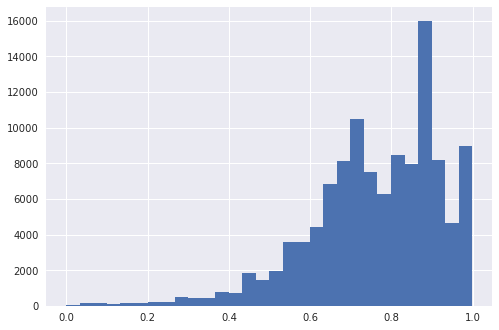

In [35]:
result.PredictedProb.hist(bins=30)

#### [Back to Plan](#planattack)

In [60]:
score = log_loss(y_test, y_pred)

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.